<a href="https://colab.research.google.com/github/MateusGheorghe/LAMP/blob/master/Step_1_TSFEL_Louise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step 1 - Data Pre-Processing and Feature Extraction
* Input - Data from matlab, raw time series from 13 probes, labels
* Output - PCS and respective Classification Labels and Regression Labels



In [70]:
# !pip install tsfel

In [71]:
# !pip install kneed

In [72]:
# !pip install mat73

In [73]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [74]:
# AIRIS=1# Using G-drive cloud AIRIS= 0 / Using AIRIS , AIRIS =1
AIRIS=1

In [75]:
if AIRIS==0:
  from google.colab import drive
  drive.mount("/gdrive")
  import os
  #os.chdir("/gdrive/My Drive/MESTRADO/ProjetoRepsol/COMSOLData/")
  #os.chdir("/gdrive/My Drive/COMSOLData/")
  # os.chdir("/gdrive/My Drive/Box0.5x0.5_Void/")
  os.chdir("/gdrive/My Drive/MESTRADO/ProjetoRepsol/PZFLEXData/Box0.5x0.5_Void/")

In [76]:
import tsfel            # time series feature extraction library
import numpy as np 
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import plotly.express as px
import scipy.linalg as sl
import pickle
import mat73

from sklearn.feature_selection import VarianceThreshold
from sklearn import preprocessing
from sklearn import decomposition
from sklearn.metrics import r2_score,mean_squared_error
from scipy.stats.mstats import zscore
from scipy.io import loadmat
from mpl_toolkits import mplot3d
from kneed import DataGenerator, KneeLocator

from scipy.signal import decimate
from math import ceil

In [77]:
# !salloc -p testing

# **Defining Functions**

In [78]:
def tic():
    #Homemade version of matlab tic and toc functions
    import time
    global startTime_for_tictoc
    startTime_for_tictoc = time.time()

def toc():
    import time
    if 'startTime_for_tictoc' in globals():
        print ('\nElapsed time is ')
        print (str(time.time() - startTime_for_tictoc))
        print('seconds.\n')
    else:
        print ('\nToc: start time not set\n')

In [79]:
def TIC():
    #Homemade version of matlab tic and toc functions
    import time
    global startTime_for_tictoc1
    startTime_for_tictoc1 = time.time()

def TOC():
    import time
    if 'startTime_for_tictoc' in globals():
        print ('\nElapsed time is ')
        print (str(time.time() - startTime_for_tictoc1))
        print('seconds.\n')
    else:
        print ('\nToc: start time not set\n')

In [80]:
def variance_threshold_select(df, thresh=0.0):
    df1 = df.copy(deep=True) # Make a deep copy of the dataframe
    selector = VarianceThreshold(thresh)
    selector.fit(df1)
    df2 = df.loc[:,selector.get_support(indices=False)] # Get new dataframe with columns deleted

    return df2


In [81]:
def matReg(y,ny):
    # create regression matrix and target vectors 

    p = np.max(ny) + 1
    (N, ) = y.shape
        
    # create target vector
    target = y[p-1:N]

    # create regression matrix
    Phi = np.zeros((N-p+1,ny))
    for i in range(ny):
        Phi[:,i]    = y[p-i-2: N - i-1]

    return (target, Phi)

In [82]:
def plot_3D_categories(Dataset,x,y,z):
  fig = px.scatter_3d(Dataset, x=x, y=y, z=z, color='Categories', size='Sev_Normalized',hover_data=[Dataset.index,'Dominant_Severity','rho_rock','rho_steel'
])
  fig.update_layout(autosize=False,width=1200,height=800)
  fig.update_layout(font=dict(size=20))
  fig.update_traces(mode='markers', marker_line_width=2)
  fig.update_layout(scene = dict(
                    xaxis = dict(tickfont=dict(size=15)),
                    yaxis = dict(tickfont=dict(size=15)),
                    zaxis = dict(tickfont=dict(size=15))
                    ))
  fig.show(renderer="colab")

In [83]:
def plot_3D_sev(Dataset,x,y,z):
  fig = px.scatter_3d(Dataset,x=x, y=y, z=z, color='Sev_Normalized', symbol='Categories',hover_data=[Dataset.index])
  fig.update_layout(autosize=False,width=1200,height=800)
  fig.update_layout(legend=dict(x=-.1, y=1.2))
  fig.update_layout(font=dict(size=20))
  fig.update_traces(mode='markers', marker_line_width=2, marker_size=10)
  fig.update_layout(scene = dict(
                    xaxis = dict(tickfont=dict(size=15)),
                    yaxis = dict(tickfont=dict(size=15)),
                    zaxis = dict(tickfont=dict(size=15))
                    ))
  fig.show(renderer="colab")

In [84]:
def plot_features_categories(Dataset,features):
  aux=[1,2,3]
  for i in range(0,np.size(Dataset,axis=0)):
    if New_Classes[i]==0:
      p1,=plt.plot(aux,features[i,:], linewidth = 1,color='blue', marker='o', markersize=5)
    elif New_Classes[i]==1:
      p2,=plt.plot(aux,features[i,:], linestyle='dashed', linewidth =  1,color='red', marker='v', markersize=5)
    elif New_Classes[i]==2:
      p3,=plt.plot(aux,features[i,:], linestyle='dashed', linewidth =  1,color='green', marker='s', markersize=5)
    elif New_Classes[i]==3:
      p4,=plt.plot(aux,features[i,:], linestyle='dashed', linewidth =  1,color='purple', marker='X', markersize=5)
    elif New_Classes[i]==4:
      p5,=plt.plot(aux,features[i,:], linestyle='dashed', linewidth =  1,color='orange', marker='*', markersize=5)
  plt.legend([p1,p2,p3,p4,p5],['ND','CH','CR','SC','CQ'],bbox_to_anchor=(1.35, 1.0), loc='upper right')
  plt.xlabel('Features') 
  plt.ylabel('Amplitude') 
  plt.show()

In [85]:
def plot_features_sev(Dataset,features):
  aux=[1,2,3]
  for i in range(0,np.size(Dataset,axis=0)):
    if SevClasses[i]==0:
      p1,=plt.plot(aux,features[i,:], linewidth = 1,color='magenta', marker='o', markersize=5)
    elif SevClasses[i]==1:
      p2,=plt.plot(aux,features[i,:], linestyle='dashed', linewidth =  1,color='yellow', marker='v', markersize=5)
    elif SevClasses[i]==2:
      p3,=plt.plot(aux,features[i,:], linestyle='dashed', linewidth =  1,color='brown', marker='s', markersize=5)
  plt.legend([p1,p2,p3],['Low','Median','High'],bbox_to_anchor=(1.35, 1.0), loc='upper right')
  plt.xlabel('Features') 
  plt.ylabel('Amplitude') 
  plt.show()

In [86]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10
from matplotlib.ticker import FuncFormatter, MaxNLocator
import matplotlib.pyplot as plt
SMALL_SIZE = 11
MEDIUM_SIZE = 21
BIGGER_SIZE = 31
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [87]:
ls 

Batches_plus_multi-defect/             slurm-1866526.out
Batches_PZTs/                          slurm-1866527.out
dask-worker-space/                     slurm-1866528.out
Datasets/                              slurm-1866540.out
DimensionalityReduction-Copy1.py       slurm-1866541.out
draw_neural_net.py                     slurm-1866542.out
ExcelFileResults/                      slurm-1866543.out
exec-Copy1.sh                          slurm-1866545.out
exec.sh                                slurm-1866546.out
FDS6.7.5_SMV6.7.15_lnx.sh              slurm-1866547.out
Features_Manifold_Learning/            slurm-1866647.out
Features_TSFEL/                        slurm-1866648.out
GridResult_500p_Classification.pickle  slurm-1866649.out
GridResult_500p_Regression.pickle      slurm-1866650.out
HPO.py*                                slurm-1866651.out
Image_Approach/                        slurm-1866652.out
logSocket                              slurm-1866653.out
myscript.py                    

# **Void caso x0 ou x1**



*   SAVE = 0 do not save / SAVE = 1 save output
*   POSITION = "r0", "r1" and "r0+r1"
*   BATCH = "1" or "2and4"

  





In [88]:
SAVE=1
POSITION='r1' #r0 / r1 / r0_r1
BATCH='1'
fs=1.4921e+07  # Fs Batch 1 = 1/mean(diff(time)) 
#BATCH='2&4' 
RESAMPLE=1
FR=20  # resampling factor 
TIC()

In [89]:
tic()
if BATCH=='1':
  if POSITION=='r0':
      ### PZFLEX DATA
      dataB1=mat73.loadmat('PZFlexData/Batch1/Original_Data/x0/Matrix_X_446_B1_x0.mat') # Batch 1 - 446 samples
      LabelB1= pd.read_csv(r'PZFlexData/Batch1/Original_Data/LABEL_B1_446.csv')
      dataB3=loadmat('PZFlexData/Batch3/Data/Interpolated_in_time_and_in_y/x0/Matrix_X_B3_x0_interpolated_in_time_and_in_y.mat') # Batch 3 - Multiple Defect 
      LabelB3= pd.read_csv(r'PZFlexData/Batch3/Data/LABEL_B3.csv')
  elif POSITION=='r1':
      dataB1=mat73.loadmat('PZFlexData/Batch1/Original_Data/x1/Matrix_X_446_B1_x1.mat') # Batch 1 - 446 samples
      LabelB1= pd.read_csv(r'PZFlexData/Batch1/Original_Data/LABEL_B1_446.csv')
      dataB3=loadmat('PZFlexData/Batch3/Data/Interpolated_in_time_and_in_y/x1/Matrix_X_B3_x1_interpolated_in_time_and_in_y.mat') # Batch 3 - Multiple Defect 
      LabelB3= pd.read_csv(r'PZFlexData/Batch3/Data/LABEL_B3.csv')
  elif POSITION=='r0_r1':
      dataB1_0=mat73.loadmat('PZFlexData/Batch1/Original_Data/x0/Matrix_X_446_B1_x0.mat') # Batch 1 - 446 samples
      dataB1_1=mat73.loadmat('PZFlexData/Batch1/Original_Data/x1/Matrix_X_446_B1_x1.mat') # Batch 1 - 446 samples
      LabelB1= pd.read_csv(r'PZFlexData/Batch1/Original_Data/LABEL_B1_446.csv')
      dataB3_0=loadmat('PZFlexData/Batch3/Data/Interpolated_in_time_and_in_y/x0/Matrix_X_B3_x0_interpolated_in_time_and_in_y.mat') # Batch 3 - Multiple Defect 
      dataB3_1=loadmat('PZFlexData/Batch3/Data/Interpolated_in_time_and_in_y/x1/Matrix_X_B3_x1_interpolated_in_time_and_in_y.mat') # Batch 3 - Multiple Defect 
      LabelB3= pd.read_csv(r'PZFlexData/Batch3/Data/LABEL_B3.csv')
elif BATCH=='2&4':
  print('Not done yet')
toc()


Elapsed time is 
53.38318991661072
seconds.



In [90]:
tic()
if BATCH=='1':
  if POSITION=="r0_r1":
    dataB1_0=np.asarray(dataB1_0['M']).T
    dataB1_1=np.asarray(dataB1_1['M']).T
    npa=np.concatenate((dataB1_0,dataB1_1),axis=1)
    LABEL_GLOBAL=LabelB1
  else:
    dataB1=np.asarray(dataB1['M']).T
    npa=dataB1
    LABEL_GLOBAL=LabelB1
elif BATCH=='2&4':
  print('Not done yet')
toc()


Elapsed time is 
0.0001742839813232422
seconds.



In [91]:
npa.shape

(446, 1163799)

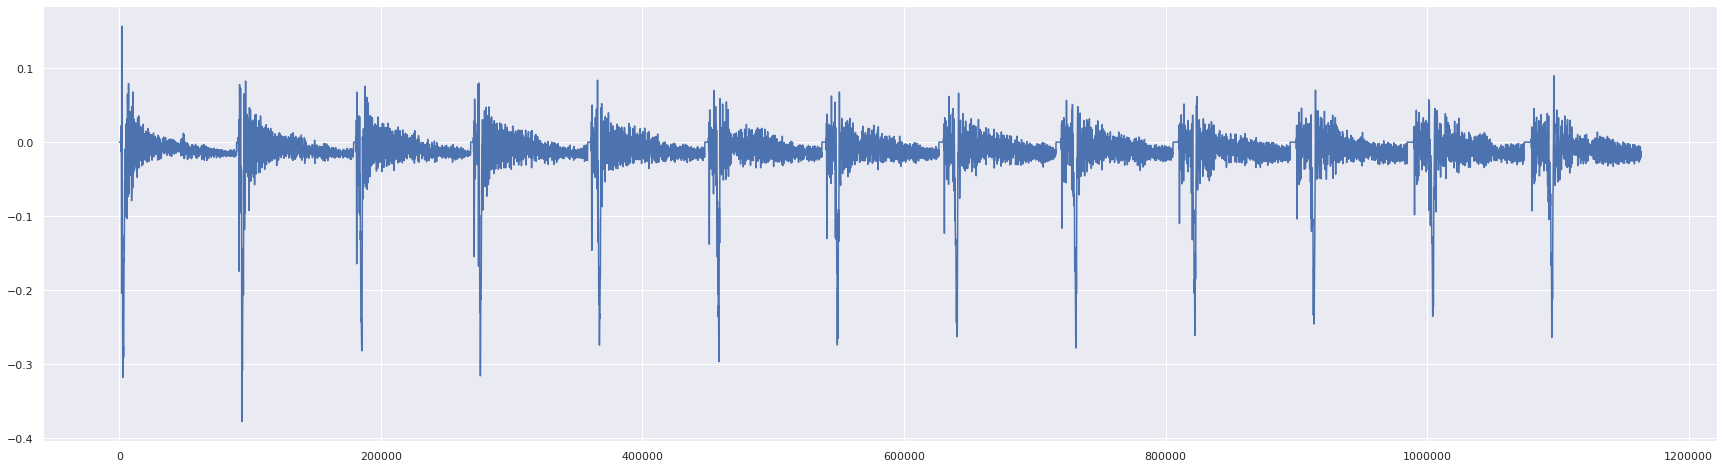

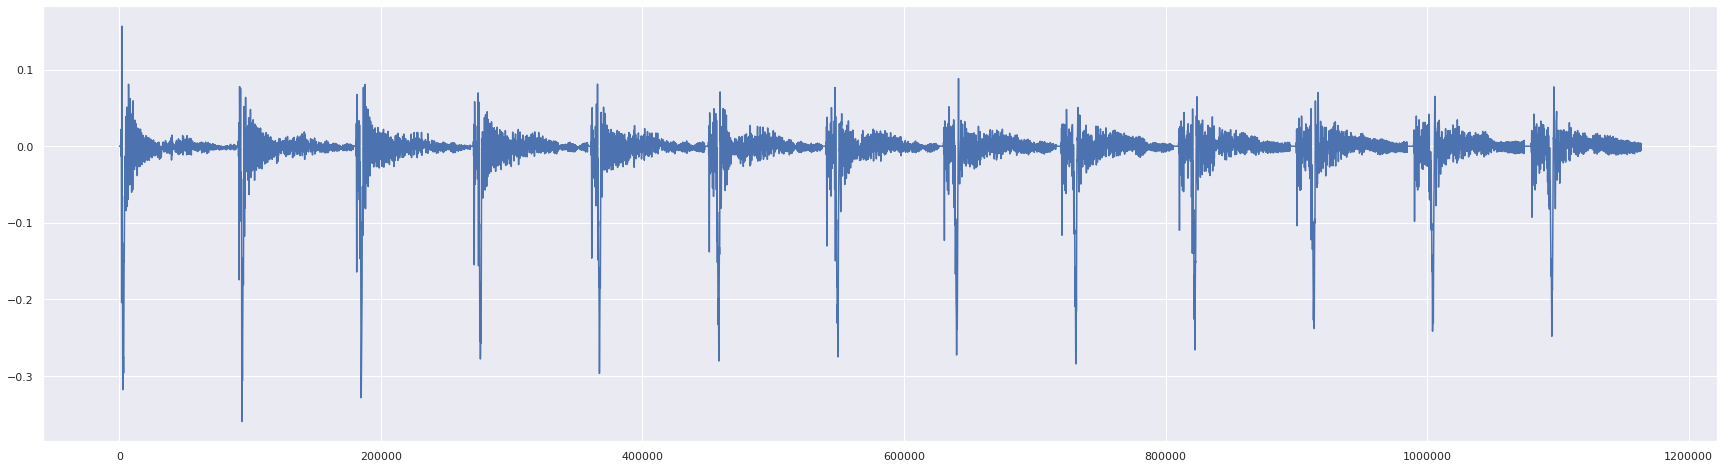

In [92]:
fig = plt.figure(figsize=(30,8))
plt.plot(npa[0,:])
plt.show()

fig = plt.figure(figsize=(30,8))
plt.plot(npa[445,:])
plt.show()


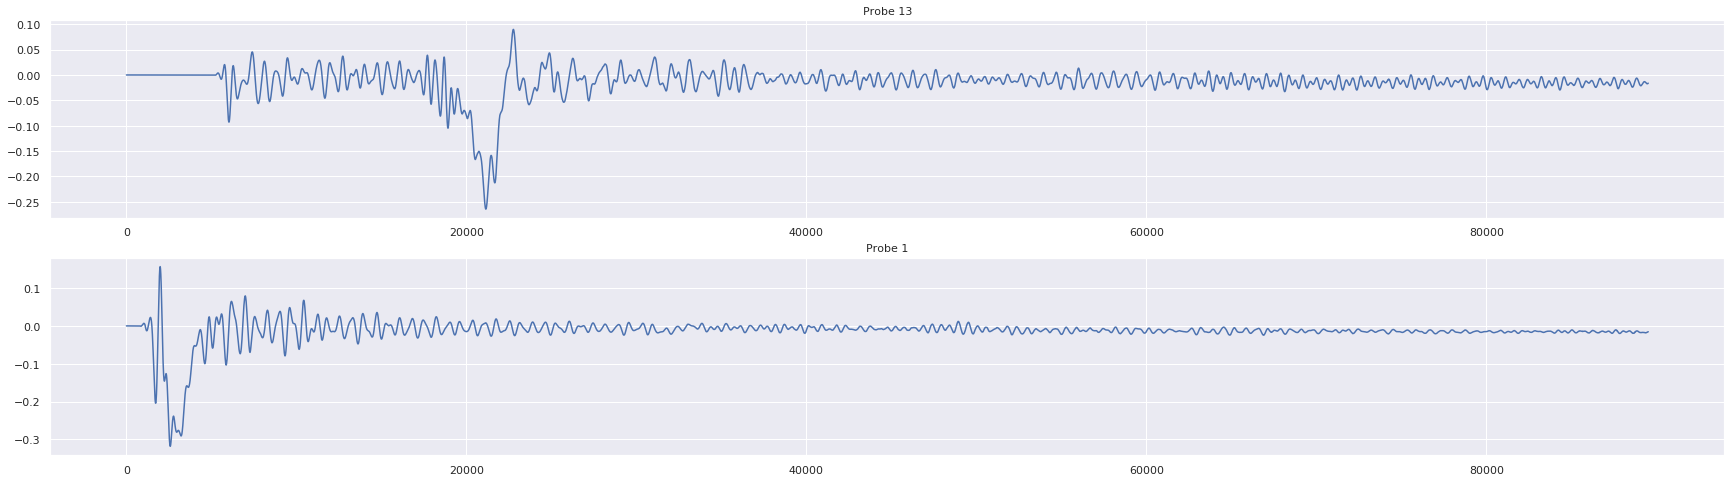

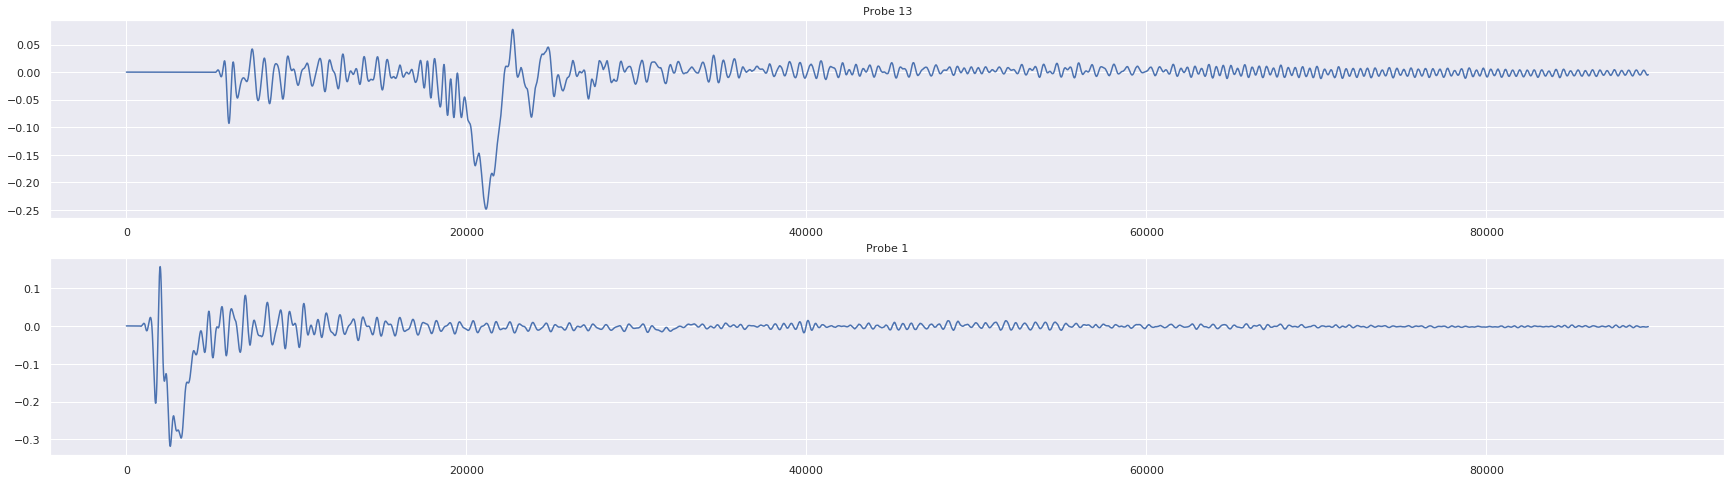

In [93]:
fig = plt.figure(figsize=(30,8))
plt.subplot(2,1,1)
plt.title('Probe 13')
plt.plot(npa[0,1163799-89523:1163799])
plt.subplot(2,1,2)
plt.title('Probe 1')
plt.plot(npa[0,0:89523])
plt.show()

fig = plt.figure(figsize=(30,8))
plt.subplot(2,1,1)
plt.title('Probe 13')
plt.plot(npa[445,1163799-89523:1163799])
plt.subplot(2,1,2)
plt.title('Probe 1')
plt.plot(npa[445,0:89523])
plt.show()

#**Pre-processing - Creating Labels / Normalize regression outputs**



In [94]:
Output_Reg=np.asarray(LABEL_GLOBAL.values[:,11])
Output_Reg = np.reshape(Output_Reg,(Output_Reg.size,1))

In [95]:
if BATCH=="1":
  Categories=LABEL_GLOBAL['Categories'].values
  Classes=LABEL_GLOBAL['Class'].values
  ND_values=LABEL_GLOBAL['ND'].values
  New_Categories=Categories
  New_Classes=Classes
  New_ND_values=ND_values
  for i in range(npa.shape[0]):
    if Output_Reg[i]<0.1:
      New_Categories[i]='ND'
      New_Classes[i]=0
      New_ND_values[i]=1
  LABEL_GLOBAL["Categories"]=New_Categories
  LABEL_GLOBAL["Class"]=New_Classes
  LABEL_GLOBAL["ND"]=New_ND_values

In [96]:
#Normalize regression label between 0 and 1
scaler=preprocessing.MinMaxScaler()
scaler.fit(Output_Reg)
Output_Reg_norm=scaler.transform(Output_Reg)

In [97]:
LABEL_GLOBAL.insert(np.size(LABEL_GLOBAL,axis=1),"Sev_Normalized",Output_Reg_norm)

In [98]:
df_Out_CatReg = pd.cut(LABEL_GLOBAL['Sev_Normalized'],bins=[-0.01,0.33, 0.66, 1],labels=['low','medium','high'])
df_Out_CatReg_Num = pd.cut(LABEL_GLOBAL['Sev_Normalized'],bins=[-0.01,0.33, 0.66, 1],labels=[0,1,2])
SevClasses=np.array(df_Out_CatReg_Num)
LABEL_GLOBAL.insert(np.size(LABEL_GLOBAL,axis=1),"Sev_Division",df_Out_CatReg)

In [99]:
LABEL_GLOBAL

,CH,CR,SC,CQ,CQ_Imped,ND,rho_cement,rho_rock,rho_steel,Categories,Class,Dominant_Severity,Sev_Normalized,Sev_Division
0,0.200,0.0,0.0,0.000000,5.4000,0,1800.0,2300,7800,CH,1,0.200000,0.243243,low
1,0.205,0.0,0.0,0.000000,5.4000,0,1800.0,2300,7800,CH,1,0.205000,0.249324,low
2,0.210,0.0,0.0,0.000000,5.4000,0,1800.0,2300,7800,CH,1,0.210000,0.255405,low
3,0.215,0.0,0.0,0.000000,5.4000,0,1800.0,2300,7800,CH,1,0.215000,0.261486,low
4,0.220,0.0,0.0,0.000000,5.4000,0,1800.0,2300,7800,CH,1,0.220000,0.267568,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441,0.000,0.0,0.0,0.099444,5.9370,1,1979.0,2300,7800,ND,0,0.099444,0.120946,low
442,0.000,0.0,0.0,0.105278,5.9685,0,1989.5,2300,7800,CQ,4,0.105278,0.128041,low
443,0.000,0.0,0.0,0.111111,6.0000,0,2000.0,2300,7800,CQ,4,0.111111,0.135135,low
444,0.000,0.0,0.0,0.116944,6.0315,0,2010.5,2300,7800,CQ,4,0.116944,0.142230,low


# Resampling


Elapsed time is 
12.152683734893799
seconds.


Elapsed time is 
14.750889778137207
seconds.

Raw   signal shape:    (446, 13, 89523)
Filt. signal shape:    (446, 13, 4477)

Raw   signal maximum:  0.15676468529168294
Filt. signal maximum:  0.15710858300962746

Raw   signal minimum: -0.37785549352426356
Filt. signal minimum: -0.37769403408470104

Sampling frequency raw signal:        1.4921e+07
Sampling frequency filtered signal:   7.4605e+05



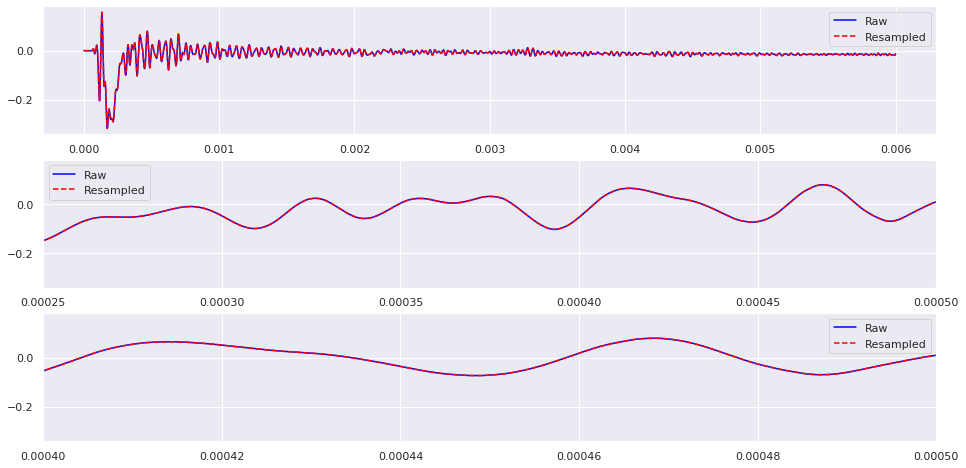

In [100]:
tic()

npa_new=np.empty(shape=(np.size(npa,axis=0),13,int(np.size(npa,axis=1)/13)))

for i in range(npa.shape[0]):
    sample=npa[i,:]
    sample_split=np.split(sample, 13, axis=0)
    for j in range(len(sample_split)):
            signal=sample_split[j].reshape(1,-1)
            npa_new[i,j,:]=signal
toc()

if RESAMPLE==1:
  fs=1.4921e+07  # sampling frequency
  ts=1/fs   # sampling time
  N=len(npa_new[0,0,])
  Tf = (N-1)/fs
  time = np.linspace(0,Tf,N) # time vector
  # we need to decimate (resample) the signal, in order to optimize feature (check zooming the signal)

  npa_res=np.ones((np.size(npa_new,axis=0),np.size(npa_new,axis=1),ceil(N/FR)))
  tic()
  for i in range(0,np.size(npa_new,axis=0)):
    for j in range(0,np.size(npa_new,axis=1)):
      npa_res[i,j,] = decimate(npa_new[i,j,], q=FR,ftype='fir') # npa resampled
  toc()
  Ns=len(npa_res[0,0,])
  fs2=1/(ts*FR)
  Tfs = (Ns-1)/fs2
  time_s = np.linspace(0,Tfs,Ns)
  plt.figure(figsize=(16,8))
  plt.subplot(311)
  plt.plot(time,npa_new[0,0,:],color='blue',label='Raw')
  plt.plot(time_s,npa_res[0,0,:],color='red',linestyle='dashed',label='Resampled')
  # plt.xlim(0, 0.25*1e-3)
  plt.legend()
  plt.subplot(312)
  plt.plot(time,npa_new[0,0,:],color='blue',label='Raw')
  plt.plot(time_s,npa_res[0,0,:],color='red',linestyle='dashed',label='Resampled')
  plt.xlim(0.25*1e-3,0.5*1e-3)
  plt.legend()
  plt.subplot(313)
  plt.plot(time,npa_new[0,0,:],color='blue',label='Raw')
  plt.plot(time_s,npa_res[0,0,:],color='red',linestyle='dashed',label='Resampled')
  plt.xlim(0.4*1e-3, 0.5*1e-3)
  plt.legend()
else:
  npa_res=npa_new

# plt.savefig('rawVsdecimated99.png')
print('Raw   signal shape:   ',npa_new.shape)
print('Filt. signal shape:   ',npa_res.shape)
print('')
print('Raw   signal maximum: ',npa[0,].max())
print('Filt. signal maximum: ',npa_res[0,].max())
print('')
print('Raw   signal minimum:',npa[0,].min())
print('Filt. signal minimum:',npa_res[0,].min())
print('')
print('Sampling frequency raw signal:        %s' % "{:.4e}".format(fs))
print('Sampling frequency filtered signal:   %s' % "{:.4e}".format(fs2))
print('')

In [101]:
npa_res.shape

(446, 13, 4477)

#**TSFEL - Statistical Features**


**Feature Extraction**

In [102]:
# tic()
# cfg_file = tsfel.get_features_by_domain('statistical') # TSFEL configuration file
# Stat= tsfel.time_series_features_extractor(cfg_file, npa_res,fs=fs) # Extracted features
# toc()

# # Visualize extracted features
# Stat.head()

In [103]:
# Stat=pd.DataFrame()
# cfg_file = tsfel.get_features_by_domain('statistical') # TSFEL configuration file
# tic()
# for i in range(0,np.size(npa_res,axis=1)):
#   Aux= tsfel.time_series_features_extractor(cfg_file,npa_res[:,i,:],fs=fs).add_suffix('_probe_'+str(i+1))# Extracted features
#   Stat=pd.concat((Stat,Aux),axis=1)
# toc()
# # Visualize extracted features
# Stat.head()

In [104]:
tic()
Stat_list = [[] for i in range(13)]
cfg_file = tsfel.get_features_by_domain('statistical') # TSFEL configuration file
for i in range(0,13):
    print('Probe %d'% (i+1))
    data=np.reshape(npa_res[:,i,:],(np.size(npa_res,axis=0),np.size(npa_res,axis=2)))
    stat= tsfel.time_series_features_extractor(cfg_file,data,fs=fs,time_unit=1) # Extracted features
    Stat_list[i].append(stat)
toc()

Probe 1
*** Feature extraction started ***



*** Feature extraction finished ***
Probe 2
*** Feature extraction started ***



*** Feature extraction finished ***
Probe 3
*** Feature extraction started ***



*** Feature extraction finished ***
Probe 4
*** Feature extraction started ***



*** Feature extraction finished ***
Probe 5
*** Feature extraction started ***



*** Feature extraction finished ***
Probe 6
*** Feature extraction started ***



*** Feature extraction finished ***
Probe 7
*** Feature extraction started ***



*** Feature extraction finished ***
Probe 8
*** Feature extraction started ***



*** Feature extraction finished ***
Probe 9
*** Feature extraction started ***



*** Feature extraction finished ***
Probe 10
*** Feature extraction started ***



*** Feature extraction finished ***
Probe 11
*** Feature extraction started ***



*** Feature extraction finished ***
Probe 12
*** Feature extraction started ***



*** Feature extraction finished ***
Probe 13
*** Feature extraction started ***



*** Feature extraction finished ***

Elapsed time is 
189.74643754959106
seconds.



In [105]:
Stat=pd.DataFrame()
for col in Stat_list[0][0].columns: 
  dfstat=pd.concat([Stat_list[0][0][col],Stat_list[1][0][col],Stat_list[2][0][col],Stat_list[3][0][col],Stat_list[4][0][col],
                   Stat_list[5][0][col],Stat_list[6][0][col],Stat_list[7][0][col],Stat_list[8][0][col],Stat_list[9][0][col],
                   Stat_list[10][0][col],Stat_list[11][0][col],Stat_list[12][0][col]],axis=1)
  aux=pd.DataFrame(dfstat.mean(axis=1),columns=[col+'_mean13'])
  Stat=pd.concat([Stat,aux],axis=1)
print(np.shape(Stat))
Stat.head()

(446, 37)


,0_ECDF Percentile Count_0_mean13,0_ECDF Percentile Count_1_mean13,0_ECDF Percentile_0_mean13,0_ECDF Percentile_1_mean13,0_ECDF Slope_mean13,0_ECDF_0_mean13,0_ECDF_1_mean13,0_ECDF_2_mean13,0_ECDF_3_mean13,0_ECDF_4_mean13,...,0_Max_mean13,0_Mean_mean13,0_Mean absolute deviation_mean13,0_Median_mean13,0_Median absolute deviation_mean13,0_Min_mean13,0_Root mean square_mean13,0_Skewness_mean13,0_Standard deviation_mean13,0_Variance_mean13
0,895.0,3581.0,-0.020131,-0.000146,26.464827,0.000223,0.000447,0.00067,0.000893,0.001117,...,0.078279,-0.013686,0.014682,-0.011470,0.007920,-0.283782,0.034062,-4.621783,0.031182,0.000977
1,895.0,3581.0,-0.020172,-0.000149,26.439012,0.000223,0.000447,0.00067,0.000893,0.001117,...,0.078442,-0.013666,0.014722,-0.011409,0.007965,-0.283913,0.034078,-4.616712,0.031208,0.000978
2,895.0,3581.0,-0.020455,-0.000162,26.186675,0.000223,0.000447,0.00067,0.000893,0.001117,...,0.078628,-0.013833,0.014784,-0.011617,0.008041,-0.284011,0.034160,-4.596717,0.031225,0.000979
3,895.0,3581.0,-0.020616,-0.000157,25.901496,0.000223,0.000447,0.00067,0.000893,0.001117,...,0.078846,-0.013891,0.014842,-0.011703,0.008108,-0.284048,0.034203,-4.580233,0.031246,0.000981
4,895.0,3581.0,-0.020642,-0.000162,25.926167,0.000223,0.000447,0.00067,0.000893,0.001117,...,0.078772,-0.013890,0.014869,-0.011675,0.008145,-0.284651,0.034245,-4.588800,0.031292,0.000983


**Feature Selection**

In [106]:
## First Selection Step

# Removal of highly correlated features
corr_features = tsfel.correlated_features(Stat)
Stat.drop(corr_features, axis=1, inplace=True)

# Visualize selected features
print(np.shape(Stat))
Stat.head()

(446, 22)


,0_ECDF Percentile Count_0_mean13,0_ECDF Percentile Count_1_mean13,0_ECDF Percentile_0_mean13,0_ECDF Percentile_1_mean13,0_ECDF_0_mean13,0_ECDF_2_mean13,0_Histogram_0_mean13,0_Histogram_1_mean13,0_Histogram_2_mean13,0_Histogram_3_mean13,...,0_Histogram_6_mean13,0_Histogram_7_mean13,0_Histogram_8_mean13,0_Histogram_9_mean13,0_Interquartile range_mean13,0_Kurtosis_mean13,0_Max_mean13,0_Min_mean13,0_Root mean square_mean13,0_Standard deviation_mean13
0,895.0,3581.0,-0.020131,-0.000146,0.000223,0.00067,0.0,0.0,0.0,38.307692,...,0.0,0.0,0.0,0.0,0.016434,30.239538,0.078279,-0.283782,0.034062,0.031182
1,895.0,3581.0,-0.020172,-0.000149,0.000223,0.00067,0.0,0.0,0.0,38.230769,...,0.0,0.0,0.0,0.0,0.016512,30.187215,0.078442,-0.283913,0.034078,0.031208
2,895.0,3581.0,-0.020455,-0.000162,0.000223,0.00067,0.0,0.0,0.0,38.384615,...,0.0,0.0,0.0,0.0,0.016673,30.047944,0.078628,-0.284011,0.034160,0.031225
3,895.0,3581.0,-0.020616,-0.000157,0.000223,0.00067,0.0,0.0,0.0,38.461538,...,0.0,0.0,0.0,0.0,0.016849,29.926797,0.078846,-0.284048,0.034203,0.031246
4,895.0,3581.0,-0.020642,-0.000162,0.000223,0.00067,0.0,0.0,0.0,38.615385,...,0.0,0.0,0.0,0.0,0.016902,30.005157,0.078772,-0.284651,0.034245,0.031292


In [107]:
## Final Selection Step

# Remove low variance features
Stat=variance_threshold_select(Stat)

# Visualize selected features
print(np.shape(Stat))
Stat.describe()

(446, 11)


,0_ECDF Percentile_0_mean13,0_ECDF Percentile_1_mean13,0_Histogram_3_mean13,0_Histogram_4_mean13,0_Histogram_5_mean13,0_Interquartile range_mean13,0_Kurtosis_mean13,0_Max_mean13,0_Min_mean13,0_Root mean square_mean13,0_Standard deviation_mean13
count,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000
mean,-0.019154,0.001492,38.706795,3241.300103,1196.993101,0.016879,28.983271,0.081572,-0.284438,0.034193,0.031861
std,0.005133,0.001469,2.724854,236.751788,237.079763,0.003748,3.292190,0.003963,0.007431,0.001443,0.000786
min,-0.025713,-0.000190,25.384615,2328.384615,964.923077,0.009371,18.924585,0.074617,-0.295741,0.031898,0.030789
25%,-0.023097,0.000047,38.615385,3160.442308,1024.288462,0.014075,26.650535,0.078705,-0.289945,0.032963,0.031213
50%,-0.020280,0.000921,39.538462,3332.269231,1105.000000,0.017724,28.369054,0.081328,-0.285802,0.034491,0.031716
75%,-0.016427,0.002510,40.307692,3413.557692,1277.423077,0.019967,31.124950,0.085346,-0.281193,0.035386,0.032514
max,-0.007096,0.005526,40.692308,3473.461538,2109.153846,0.021695,35.154448,0.087811,-0.259355,0.036543,0.033650


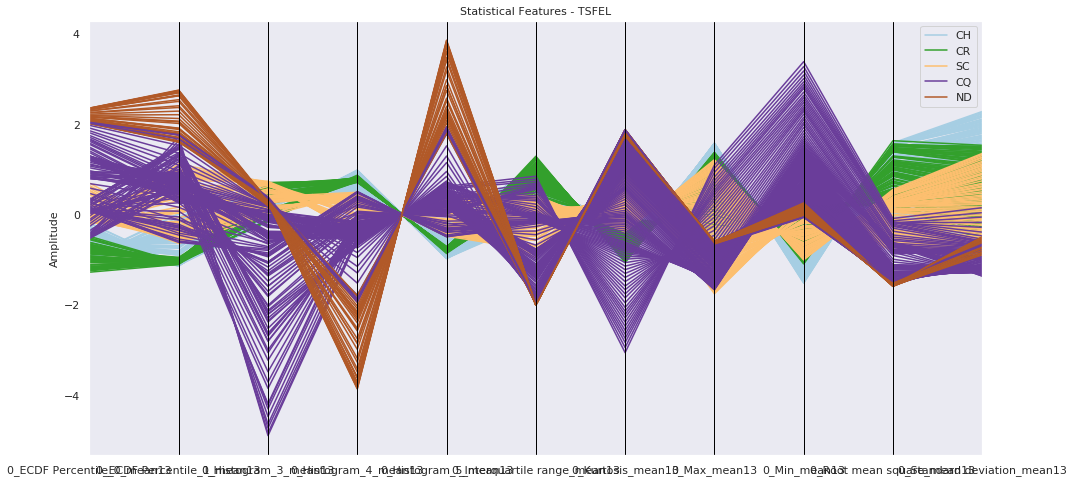

In [108]:
# Scale Data
std_scaler=preprocessing.StandardScaler()
Stat_scaled=std_scaler.fit_transform(Stat.values)

DFStat = pd.DataFrame(Stat_scaled, columns=Stat.columns)        

DFStat_cat=pd.concat([LABEL_GLOBAL['Categories'],DFStat], axis=1)


plt.figure(figsize=(16,8))
pd.plotting.parallel_coordinates(DFStat_cat, 'Categories',colormap=plt.get_cmap('Paired'))
# naming the y axis 
plt.ylabel('Amplitude') 
# giving a title to my graph 
plt.title('Statistical Features - TSFEL') 
plt.show()

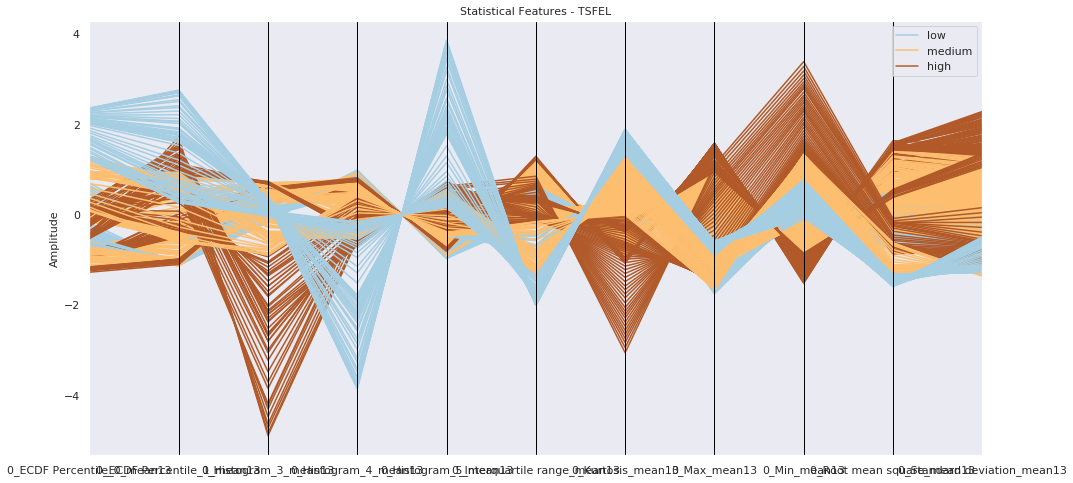

In [109]:
DFStat_sev=pd.concat([LABEL_GLOBAL['Sev_Division'],DFStat], axis=1)

plt.figure(figsize=(16,8))
pd.plotting.parallel_coordinates(DFStat_sev, 'Sev_Division',colormap=plt.get_cmap('Paired'))
# naming the y axis 
plt.ylabel('Amplitude') 
# giving a title to my graph 
plt.title('Statistical Features - TSFEL') 
plt.show()

In [111]:
Dataset_Stat=pd.concat([LABEL_GLOBAL,DFStat], axis=1)
plot_3D_categories(Dataset_Stat,'0_ECDF Percentile_0_mean13','0_Histogram_5_mean13','0_Histogram_5_mean13')

In [ ]:
plot_3D_sev(Dataset_Stat,'0_ECDF Percentile_0_mean13','0_Histogram_5_mean13','0_Mean_mean13')

# **TSFEL - Temporal Features**

**Feature Extraction**

In [112]:
# tic()
# cfg_file = tsfel.get_features_by_domain('temporal') # TSFEL configuration file
# Temp= tsfel.time_series_features_extractor(cfg_file, npa,fs=fs) # Extracted features
# toc()

# # Visualize extracted features
# Temp.head()

In [113]:
# Temp=pd.DataFrame()
# cfg_file = tsfel.get_features_by_domain('temporal') # TSFEL configuration file
# tic()
# for i in range(0,np.size(npa_res,axis=1)):
#   Aux= tsfel.time_series_features_extractor(cfg_file,npa_res[:,i,:],fs=fs).add_suffix('_probe_'+str(i+1))# Extracted features
#   Temp=pd.concat((Stat,Aux),axis=1)
# toc()
# # Visualize extracted features
# Temp.head()

In [114]:
tic()
Temp_list = [[] for i in range(13)]
cfg_file = tsfel.get_features_by_domain('temporal') # TSFEL configuration file
for i in range(0,13):
    print('Probe %d'% (i+1))
    data=np.reshape(npa_res[:,i,:],(np.size(npa_res,axis=0),np.size(npa_res,axis=2)))
    temp= tsfel.time_series_features_extractor(cfg_file,data,fs=fs,time_unit=1) # Extracted features
    Temp_list[i].append(temp)
toc()

Probe 1
*** Feature extraction started ***



*** Feature extraction finished ***
Probe 2
*** Feature extraction started ***



*** Feature extraction finished ***
Probe 3
*** Feature extraction started ***



*** Feature extraction finished ***
Probe 4
*** Feature extraction started ***



*** Feature extraction finished ***
Probe 5
*** Feature extraction started ***



*** Feature extraction finished ***
Probe 6
*** Feature extraction started ***



*** Feature extraction finished ***
Probe 7
*** Feature extraction started ***



*** Feature extraction finished ***
Probe 8
*** Feature extraction started ***



*** Feature extraction finished ***
Probe 9
*** Feature extraction started ***



*** Feature extraction finished ***
Probe 10
*** Feature extraction started ***



*** Feature extraction finished ***
Probe 11
*** Feature extraction started ***



*** Feature extraction finished ***
Probe 12
*** Feature extraction started ***



*** Feature extraction finished ***
Probe 13
*** Feature extraction started ***



*** Feature extraction finished ***

Elapsed time is 
190.47010397911072
seconds.



In [115]:
Temp=pd.DataFrame()
for col in Temp_list[0][0].columns: 
  dftemp=pd.concat([Temp_list[0][0][col],Temp_list[1][0][col],Temp_list[2][0][col],Temp_list[3][0][col],Temp_list[4][0][col],
                   Temp_list[5][0][col],Temp_list[6][0][col],Temp_list[7][0][col],Temp_list[8][0][col],Temp_list[9][0][col],
                   Temp_list[10][0][col],Temp_list[11][0][col],Temp_list[12][0][col]],axis=1)
  aux=pd.DataFrame(dftemp.mean(axis=1),columns=[col+'_mean13'])
  Temp=pd.concat([Temp,aux],axis=1)
print(np.shape(Temp))
Temp.head()

(446, 18)


,0_Absolute energy_mean13,0_Area under the curve_mean13,0_Autocorrelation_mean13,0_Centroid_mean13,0_Entropy_mean13,0_Mean absolute diff_mean13,0_Mean diff_mean13,0_Median absolute diff_mean13,0_Median diff_mean13,0_Negative turning points_mean13,0_Neighbourhood peaks_mean13,0_Peak to peak distance_mean13,0_Positive turning points_mean13,0_Signal distance_mean13,0_Slope_mean13,0_Sum absolute diff_mean13,0_Total energy_mean13,0_Zero crossing rate_mean13
0,5.210764,0.000005,5.210764,0.000061,0.988335,0.002131,-0.000002,0.001415,0.000002,177.692308,155.692308,0.362060,177.307692,4476.025492,0.000001,9.539116,17370.376589,153.615385
1,5.215640,0.000005,5.215640,0.000061,0.988335,0.002138,-0.000002,0.001422,0.000002,177.230769,155.153846,0.362354,176.846154,4476.025590,0.000001,9.571355,17386.630273,155.461538
2,5.240904,0.000006,5.240904,0.000062,0.988335,0.002146,-0.000002,0.001430,0.000002,176.538462,154.769231,0.362639,176.153846,4476.025690,0.000001,9.604712,17470.850703,153.923077
3,5.254103,0.000006,5.254103,0.000062,0.988335,0.002153,-0.000002,0.001438,0.000002,176.230769,154.384615,0.362894,175.846154,4476.025787,0.000001,9.636532,17514.849160,153.769231
4,5.266587,0.000006,5.266587,0.000062,0.988335,0.002158,-0.000002,0.001442,0.000001,175.846154,153.846154,0.363423,175.461538,4476.025863,0.000001,9.660821,17556.465512,154.230769


**Feature Selection**

In [116]:
## First Selection Step

# Removal of highly correlated features
corr_features = tsfel.correlated_features(Temp)
Temp.drop(corr_features, axis=1, inplace=True)

# Visualize selected features
print(np.shape(Temp))
Temp.head()

(446, 7)


,0_Absolute energy_mean13,0_Entropy_mean13,0_Mean absolute diff_mean13,0_Mean diff_mean13,0_Median diff_mean13,0_Negative turning points_mean13,0_Peak to peak distance_mean13
0,5.210764,0.988335,0.002131,-0.000002,0.000002,177.692308,0.362060
1,5.215640,0.988335,0.002138,-0.000002,0.000002,177.230769,0.362354
2,5.240904,0.988335,0.002146,-0.000002,0.000002,176.538462,0.362639
3,5.254103,0.988335,0.002153,-0.000002,0.000002,176.230769,0.362894
4,5.266587,0.988335,0.002158,-0.000002,0.000001,175.846154,0.363423


In [117]:
## Final Selection Step

# Remove low variance features
Temp=variance_threshold_select(Temp)

# Visualize selected features
print(np.shape(Temp))
Temp.head()

(446, 6)


,0_Absolute energy_mean13,0_Mean absolute diff_mean13,0_Mean diff_mean13,0_Median diff_mean13,0_Negative turning points_mean13,0_Peak to peak distance_mean13
0,5.210764,0.002131,-0.000002,0.000002,177.692308,0.362060
1,5.215640,0.002138,-0.000002,0.000002,177.230769,0.362354
2,5.240904,0.002146,-0.000002,0.000002,176.538462,0.362639
3,5.254103,0.002153,-0.000002,0.000002,176.230769,0.362894
4,5.266587,0.002158,-0.000002,0.000001,175.846154,0.363423


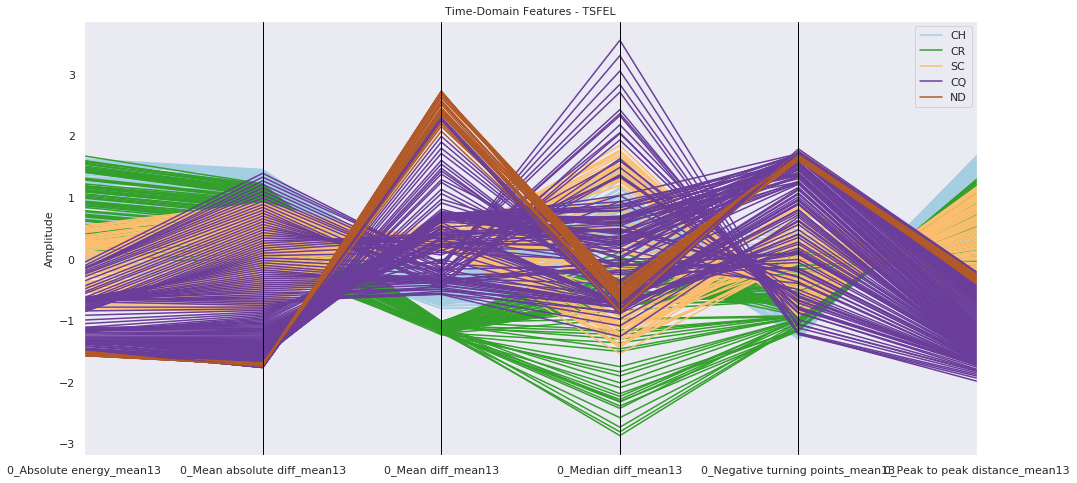

In [118]:
# Scale Data
std_scaler=preprocessing.StandardScaler()
Temp_scaled=std_scaler.fit_transform(Temp.values)

DFTemp = pd.DataFrame(Temp_scaled, columns=Temp.columns)        

DFTemp_cat=pd.concat([LABEL_GLOBAL['Categories'],DFTemp], axis=1)


plt.figure(figsize=(16,8))
pd.plotting.parallel_coordinates(DFTemp_cat, 'Categories',colormap=plt.get_cmap('Paired'))
# naming the y axis 
plt.ylabel('Amplitude') 
# giving a title to my graph 
plt.title('Time-Domain Features - TSFEL') 
plt.show()

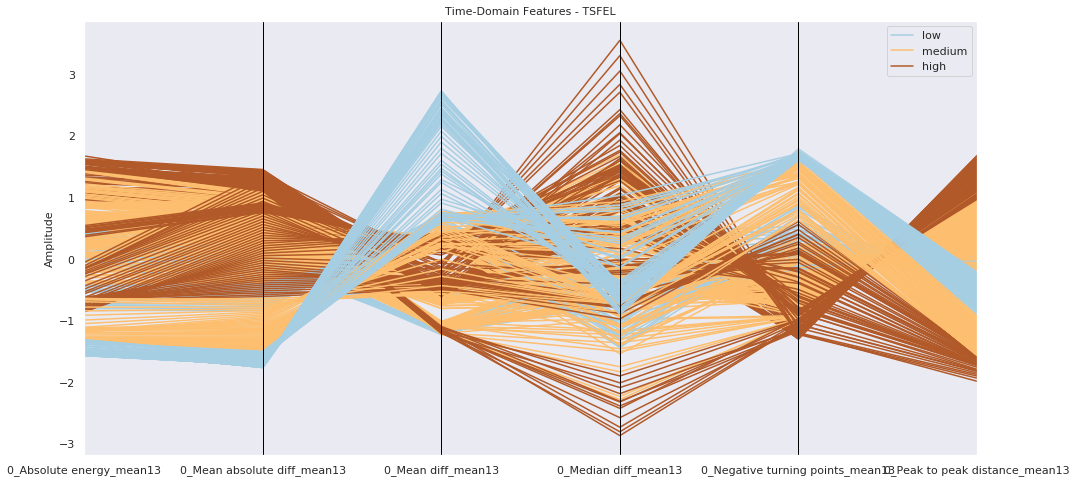

In [119]:
DFTemp_sev=pd.concat([LABEL_GLOBAL['Sev_Division'],DFTemp], axis=1)

plt.figure(figsize=(16,8))
pd.plotting.parallel_coordinates(DFTemp_sev, 'Sev_Division',colormap=plt.get_cmap('Paired'))
# naming the y axis 
plt.ylabel('Amplitude') 
# giving a title to my graph 
plt.title('Time-Domain Features - TSFEL') 
plt.show()

In [121]:
Dataset_Temp=pd.concat([LABEL_GLOBAL,DFTemp], axis=1)
plot_3D_categories(Dataset_Temp,'0_Absolute energy_mean13','0_Median diff_mean13','0_Peak to peak distance_mean13')


In [123]:
plot_3D_sev(Dataset_Temp,'0_Absolute energy_mean13','0_Median diff_mean13','0_Peak to peak distance_mean13')

# **AR Model**

In [ ]:
# nyvec = np.array((1,2,3,4,5,10,15,20)) #,25,30,35,40,45,50)) That amount of coeficients is not necessary
# lny, = nyvec.shape # how many ny 

# nfiles = npa.shape[0]

# tic()
# # store metrics and
# R2 = np.zeros((nyvec.size,nfiles))
# MSE = np.zeros((nyvec.size,nfiles))
# Mean_R2=np.zeros((nyvec.size,1))
# ARcoefs = []                 # initialize an empty list
# AllPhis = []
# cont=0

# for j in range(lny):
#     ny = nyvec[j]
#     AR = np.zeros((nfiles,ny))
#     print('ny %d' % ny)
#     for i in range(nfiles):    
#             target, Phi = matReg(npa[i,],ny)
#             th_hat, res, rnk, s = sl.lstsq(Phi, target)
#             yhat = np.matmul(Phi,th_hat)
#             AR[i,] = th_hat
#             R2[j,i] = r2_score(target, yhat)
#             MSE[j,i] = mean_squared_error(target, yhat)
#     ARcoefs.append(AR)
#     Mean_R2[cont]=np.mean(R2[j,:])
#     cont=cont+1

In [ ]:
# x = np.squeeze(nyvec)
# y = np.squeeze(Mean_R2)

# kn = KneeLocator(x,y,curve='concave',direction='increasing', S=7, interp_method='interp1d')
# print(kn.knee)

# plt.xlabel('ny')
# plt.ylabel('R2')
# plt.title('R2 vs ny')
# plt.xticks(range(1,21))
# plt.plot(x, y, 'bx-')
# plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')

In [ ]:
# if isinstance(kn.knee,(np.int64)):
#   ARsel=ARcoefs[kn.knee-1]
#   print('ny={}'.format(kn.knee))
#   nyAR=kn.knee
# else:
#   print('ny={}'.format(ny))
#   # nyAR=ny
#   nyAR=3
# ARsel=ARcoefs[2]

In [ ]:
# ARsel=pd.DataFrame(ARsel)
# std_scaler=preprocessing.StandardScaler()
# AR_scaled=std_scaler.fit_transform(ARsel.values)

# DFAR = pd.DataFrame(AR_scaled, columns=ARsel.columns)     

# DFAR_cat=pd.concat([LABEL_GLOBAL['Categories'],DFAR], axis=1)


# plt.figure(figsize=(16,8))
# pd.plotting.parallel_coordinates(DFAR_cat, 'Categories',colormap=plt.get_cmap('Paired'))
# # naming the y axis 
# plt.ylabel('Amplitude') 
# # giving a title to my graph 
# plt.title('AR Features') 
# plt.show()

In [ ]:
# DFAR_sev=pd.concat([LABEL_GLOBAL['Sev_Division'],DFAR], axis=1)

# plt.figure(figsize=(16,8))
# pd.plotting.parallel_coordinates(DFAR_sev, 'Sev_Division',colormap=plt.get_cmap('Paired'))
# # naming the y axis 
# plt.ylabel('Amplitude') 
# # giving a title to my graph 
# plt.title('AR Features')  
# plt.show()

In [ ]:
# Dataset_AR=pd.concat([LABEL_GLOBAL,DFAR], axis=1)
# plot_3D_categories(Dataset_AR,0,1,2)

In [ ]:
# plot_3D_sev(Dataset_AR,0,1,2)

# **AR Model 2**

In [ ]:
# nominal = npa[0]
# new_npa = np.empty(shape=npa.shape)

# for i in range(npa.shape[0]):
#   new_npa[i] = npa[i] - nominal

# new_npa = np.delete(new_npa,0,axis=0)
# new_npa.shape

In [ ]:
# nyvec = np.array((1,2,3))#,4,5,10,15,20)) #,25,30,35,40,45,50))
# lny, = nyvec.shape # how many ny 

# nfiles = new_npa.shape[0]

# tic()
# # store metrics and
# R2 = np.zeros((nyvec.size,nfiles))
# MSE = np.zeros((nyvec.size,nfiles))
# Mean_R2=np.zeros((nyvec.size,1))
# ARcoefs = []                 # initialize an empty list
# AllPhis = []
# cont=0

# for j in range(lny):
#     ny = nyvec[j]
#     AR = np.zeros((nfiles,ny))
#     print('ny %d' % ny)
#     for i in range(nfiles):    
#             target, Phi = matReg(new_npa[i,],ny)
#             th_hat, res, rnk, s = sl.lstsq(Phi, target)
#             yhat = np.matmul(Phi,th_hat)
#             AR[i,] = th_hat
#             R2[j,i] = r2_score(target, yhat)
#             MSE[j,i] = mean_squared_error(target, yhat)
#     ARcoefs.append(AR)
#     Mean_R2[cont]=np.mean(R2[j,:])
#     cont=cont+1

In [ ]:
# x = np.squeeze(nyvec)
# y = np.squeeze(Mean_R2)

# kn = KneeLocator(x,y,curve='concave',direction='increasing', S=1, interp_method='interp1d')
# print(kn.knee)

# plt.xlabel('ny')
# plt.ylabel('R2')
# plt.title('R2 vs ny - Baseline')
# plt.xticks(range(1,21))
# plt.plot(x, y, 'bx-')
# plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')

In [ ]:
# if isinstance(kn.knee,(np.int64)):
#   ARsel=ARcoefs[kn.knee-1]
#   print('ny={}'.format(kn.knee))
#   nyAR=kn.knee
# else:
#   print('ny={}'.format(ny))
#   nyAR=ny
# ARsel=ARcoefs[2]

In [ ]:
# New_LABEL_GLOBAL = LABEL_GLOBAL.drop(0)
# for i in range(new_npa.shape[0]):
#   New_LABEL_GLOBAL = New_LABEL_GLOBAL.rename({i+1: i}, axis='index')
# New_LABEL_GLOBAL

In [ ]:
# ARsel=pd.DataFrame(ARsel)
# std_scaler=preprocessing.StandardScaler()
# AR_scaled=std_scaler.fit_transform(ARsel.values)

# DFAR = pd.DataFrame(AR_scaled, columns=ARsel.columns)     

# DFAR_cat=pd.concat([New_LABEL_GLOBAL['Categories'],DFAR], axis=1)


# plt.figure(figsize=(16,8))
# pd.plotting.parallel_coordinates(DFAR_cat, 'Categories',colormap=plt.get_cmap('Paired'))
# # naming the y axis 
# plt.ylabel('Amplitude') 
# # giving a title to my graph 
# plt.title('AR Features') 
# plt.show()

In [ ]:
# DFAR_sev=pd.concat([New_LABEL_GLOBAL['Sev_Division'],DFAR], axis=1)

# plt.figure(figsize=(16,8))
# pd.plotting.parallel_coordinates(DFAR_sev, 'Sev_Division',colormap=plt.get_cmap('Paired'))
# # naming the y axis 
# plt.ylabel('Amplitude') 
# # giving a title to my graph 
# plt.title('AR Features')  
# plt.show()

In [ ]:
# Dataset_AR_2=pd.concat([New_LABEL_GLOBAL,DFAR], axis=1)
# plot_3D_categories(Dataset_AR_2,0,1,2)

In [ ]:
# plot_3D_sev(Dataset_AR_2,0,1,2)

# Saving Data

In [124]:
if SAVE==1:
    with open('Features_TSFEL/Dataset_Stat_'+str(POSITION)+'_Batch_'+str(BATCH)+'.pickle', 'wb') as filename:
        pickle.dump(Dataset_Stat, filename)
    with open('Features_TSFEL/Dataset_Temp_'+str(POSITION)+'_Batch_'+str(BATCH)+'.pickle', 'wb') as filename:
        pickle.dump(Dataset_Temp, filename)
    # with open('Features_TSFEL/Dataset_AR_'+str(POSITION)+'_Batch_'+str(BATCH)+'.pickle', 'wb') as filename:
    #     pickle.dump(Dataset_AR, filename)
    # with open('Features_TSFEL/Dataset_AR_2_'+str(POSITION)+'_Batch_'+str(BATCH)+'.pickle', 'wb') as filename:
    #     pickle.dump(Dataset_AR_2, filename)